# Final Model Evaluation Notebook

This notebook consists of an evaluation of our best model for the Forest Cover Type Prediction competition. Our best model is an Extra Trees model, which outperformed our ensemble. 

# Import Statements

First, we will import the necessary packages for data manipulation and analysis.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import joblib
import sklearn 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from keras.metrics import top_k_categorical_accuracy

In [2]:
# load data
train = pd.read_csv('../input/forest-cover-type-prediction/train.csv')
# view data
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


# Preprocessing

Next, we will preprocess the data to remove the ID column from the set, add new features from our feature engineering and PCA analysis, split the data into training and validation sets, and scale the data. 

In [3]:
# remove ID column from set
train = train.iloc[:, 1:]
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [4]:
# add new features from feature engineering
train['Elev_to_Horizontal_Hyd'] = train.Elevation - 0.2 * train.Horizontal_Distance_To_Hydrology 
train['Elev_to_Horizontal_Road'] = train.Elevation - 0.05 * train.Horizontal_Distance_To_Roadways  
train['Elev_to_Verticle_Hyd'] = train.Elevation - train.Vertical_Distance_To_Hydrology 
train['Mean_Horizontal_Dist'] = (train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology + 
                                 train.Horizontal_Distance_To_Roadways)/3 
train['Mean_Fire_Hydro'] = (train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology)/2

In [5]:
# move target to first column
first_column = train.pop('Cover_Type')
  
# insert column using insert(position,column_name,first_column) function
train.insert(0, 'Cover_Type', first_column)
  
# view
train.head()

,Cover_Type,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Elev_to_Horizontal_Hyd,Elev_to_Horizontal_Road,Elev_to_Verticle_Hyd,Mean_Horizontal_Dist,Mean_Fire_Hydro
0,5,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,2544.4,2570.50,2596,2349.000000,3268.5
1,5,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,2547.6,2570.50,2596,2275.666667,3218.5
2,2,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,2750.4,2645.00,2739,3189.666667,3194.5
3,2,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,2736.6,2630.50,2667,3181.000000,3226.5
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,2564.4,2575.45,2596,2238.666667,3162.5


In [6]:
# create cat, num, and y
X_cat = train.iloc[:, 11:55].values
B = train.iloc[:, 55:60]
A = train.iloc[:, 1:11]
X_num = pd.concat([A, B], axis = 1).values
y = train.iloc[:, 0].values

In [7]:
# scale/standardizing numerical columns
# scaler object
scaler = StandardScaler()
# fit to training data
scaler.fit(X_num)
# scale num columns
X_num = scaler.transform(X_num)

# shape
print(f'Categorical Shape: {X_cat.shape}')
print(f'Numerical Shape: {X_num.shape}')
print(f'Label Shape: {y.shape}')

Categorical Shape: (15120, 44)
Numerical Shape: (15120, 15)
Label Shape: (15120,)


In [8]:
# combine num and cat
X = np.hstack((X_num, X_cat))
print(X.shape)

(15120, 59)


In [9]:
# train/validate split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = .20, random_state = 1)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(12096, 59)
(3024, 59)
(12096,)
(3024,)


# Load Model

Below, we will load in the best model from our Training Model Notebook and fit it to the training set. Normally, we would not refit the model, but we are interested in exploring the strength of the model by splitting the training set into a training and validation set, so we need to refit it to the training portion of the data.

In [10]:
# load final model
final_model = joblib.load('../input/g2-forestcovertype-finalmodels/tree_model_final.joblib')

In [11]:
# fit model to training set 
final_model.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=33, n_estimators=1000, random_state=1)

# Accuracy
As we do not have access to the labels for the test set for the Forest Cover Type competition, we are going to examine the accuracy of the model with a validation set. 

In [12]:
# score for training set
train_acc = final_model.score(X_train, y_train)
# score for validation set
valid_acc = final_model.score(X_valid, y_valid)

print('Training Accuracy for Final Model', {round(train_acc, 4)})
print('Validation Accuracy for Final Model', {round(valid_acc, 4)})

Training Accuracy for Final Model {1.0}
Validation Accuracy for Final Model {0.8932}


The training accuracy for the model is 1.0, with the validation accuracy at .8932. This means that the model is overfitting the training set. 
The validation score is .8932 and the test score accuracy is .7962. This means that the model is fitting the validation set better than the test set. 

In [13]:
# predictions
valid_pred = final_model.predict(X_valid)
# prob predictions
valid_proba = final_model.predict_proba(X_valid)

# Top K-Accuracy

We will now explore the accuracy of the final model by calculating the top number of successes of finding the actual label in the top 2 and 3 predicted labels.

In [14]:
def top_k_accuracy(y_true, pred_prob, K):
    count = 0
    for i in range(len(y_true)):
        p = pred_prob[i, :]          # Get predictions for current observation
        rank = np.argsort(p) + 1     # Rank classes in increasing order; add 1 to get from 0-6 to 1-7 for label
        correct = y_true[i]          # Get correct class.
        if correct in rank[-K:]:     # See if correct class is in top k
            count += 1               # Increment count if so.

    return count / len(y_true)       # Return score

In [15]:
# calculate accuracy for top 2 predictions
top_2_accuracy = top_k_accuracy(y_valid, valid_proba, 2)
print(round(top_2_accuracy, 4))

0.9798


In [16]:
# calculate accuracy for top 3 predictions
top_3_accuracy = top_k_accuracy(y_valid, valid_proba, 3)
print(round(top_3_accuracy, 4))

0.9954


While the model is 89.32% accurate on the validation set for predicting the correct label, the model is 97.98% accurate at predicting the label that is in the top 2 for each cover type and 99.54% accurate at predicting the label that is within the top 3 for each cover type. If selecting a model where predicting within the top 2 classifications were acceptable, then this model would be very strong. 

# Classification Report

One of the ways to assess the accuracy of our model is through examining precision and recall. The classification report below includes the precision and recall for each cover type. 

In [17]:
# classification report
c_report = classification_report(y_valid, valid_pred)
print(c_report)

              precision    recall  f1-score   support

           1       0.81      0.78      0.80       434
           2       0.83      0.74      0.78       458
           3       0.91      0.90      0.90       437
           4       0.96      0.98      0.97       447
           5       0.90      0.96      0.93       418
           6       0.90      0.94      0.92       411
           7       0.92      0.97      0.95       419

    accuracy                           0.89      3024
   macro avg       0.89      0.90      0.89      3024
weighted avg       0.89      0.89      0.89      3024



Precision = TP/TP + FP

Recall = TP/TP + FN

- The model precision was highest for Cover Type 4. 
- The model recall was highest for Cover Type 4 as well. 
- The model also yielded the highest f1-score for Cover Type 4. 

This makes sense as the support for Cover Type 4 was among the top 2 most common cover types in the data set. 


# Confusion Matrix

We will now examine the accuracy of the model via a confusion matrix. The confusion matrix displays the number of times the cover type was classified correctly and how many times it was misclassified as another cover type. 

In [18]:
# confusion matrix
cm = confusion_matrix(y_valid, valid_pred)
cm_df = pd.DataFrame(cm)
# Change the column names
cm_df.columns =[1, 2, 3, 4, 5, 6, 7]
cm_df.index = [1, 2, 3, 4, 5, 6, 7]
# display
cm_df

,1,2,3,4,5,6,7
1,340,57,0,0,5,0,32
2,68,338,10,0,33,8,1
3,0,1,392,13,4,27,0
4,0,0,5,440,0,2,0
5,0,6,7,0,401,4,0
6,0,3,16,5,2,385,0
7,12,2,0,0,0,0,405


# Distribution of Class Probability Predictions

In this section, we provide some histograms displaying the distributions of probability estimates generated for each label.

In [19]:
# validation predictions data frame
df_prob = pd.DataFrame(valid_proba)
df_prob.columns = [1, 2, 3, 4, 5, 6, 7]
df_prob

,1,2,3,4,5,6,7
0,0.000000,0.016106,0.068118,0.0,0.000000,0.915776,0.000000
1,0.371000,0.425000,0.000000,0.0,0.202000,0.002000,0.000000
2,0.001083,0.002000,0.000000,0.0,0.000000,0.000000,0.996917
3,0.006087,0.276991,0.000054,0.0,0.716868,0.000000,0.000000
4,0.360165,0.559063,0.000000,0.0,0.080688,0.000000,0.000083
...,...,...,...,...,...,...,...
3019,0.011852,0.094562,0.001048,0.0,0.890405,0.002133,0.000000
3020,0.022944,0.071591,0.000000,0.0,0.905412,0.000053,0.000000
3021,0.838245,0.150612,0.000000,0.0,0.007143,0.001000,0.003000
3022,0.001000,0.000000,0.000000,0.0,0.000000,0.000000,0.999000


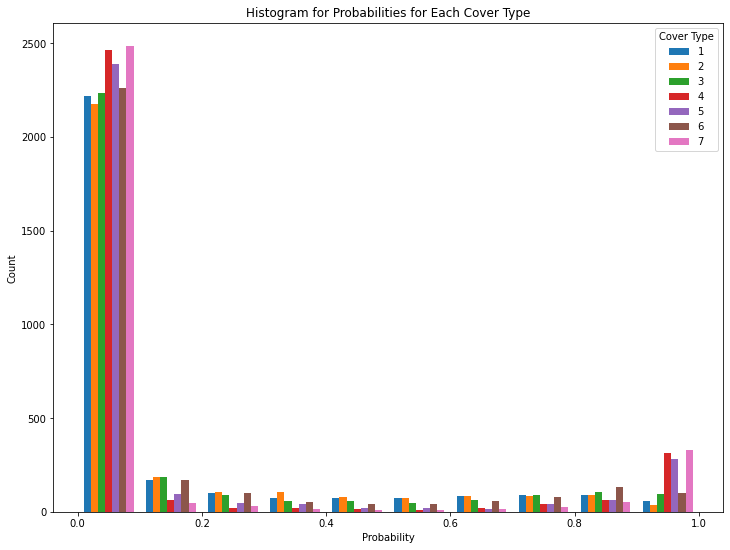

In [20]:
# histogram chart for probabilities by cover type
plt.figure(figsize = [12,9])
plt.hist(df_prob)
plt.title('Histogram for Probabilities for Each Cover Type')
plt.ylabel('Count')
plt.xlabel('Probability')
plt.legend([1, 2, 3, 4, 5, 6, 7], title = 'Cover Type')
plt.show()

These visualizations provide us with information about the labels that our model is more likely to predict, or if there are labels that it tends to be more or less confident about.

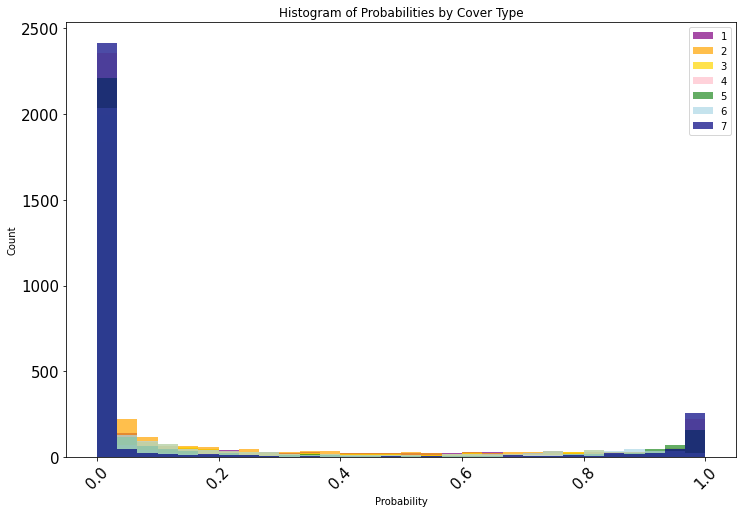

In [21]:
df_prob.plot(kind = 'hist',
        alpha = 0.7,
        bins = 30,
        title = 'Histogram of Probabilities by Cover Type',
        rot = 45,
        grid = False,
        figsize = (12,8),
        fontsize = 15, 
        color = ['purple', 'orange', 'gold', 'pink', 'forestgreen', 'lightblue', 'navy'])
plt.xlabel('Probability')
plt.ylabel("Count");

In [22]:
maxValueIndex = df_prob.idxmax(axis=1)
maxValues = df_prob.max(axis=1)
pred_prob = pd.concat([maxValueIndex, maxValues], axis=1)
df_1 = pred_prob.loc[lambda x: x[0] == 1]
df_2 = pred_prob.loc[lambda x: x[0] == 2]
df_3 = pred_prob.loc[lambda x: x[0] == 3]
df_4 = pred_prob.loc[lambda x: x[0] == 4]
df_5 = pred_prob.loc[lambda x: x[0] == 5]
df_6 = pred_prob.loc[lambda x: x[0] == 6]
df_7 = pred_prob.loc[lambda x: x[0] == 7]

<Figure size 1296x648 with 0 Axes>

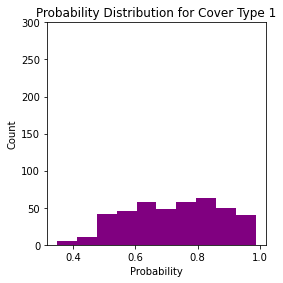

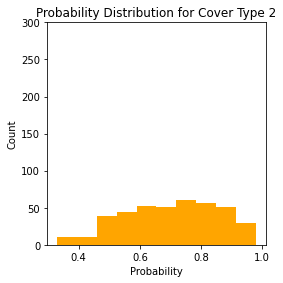

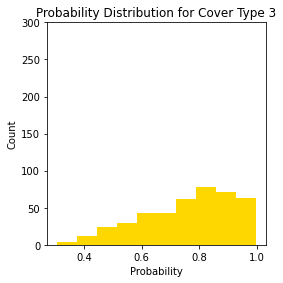

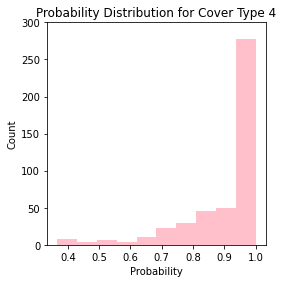

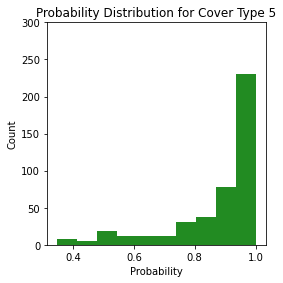

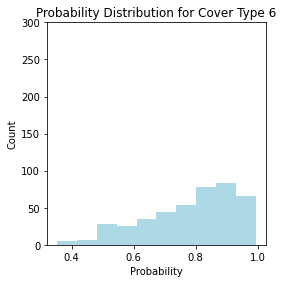

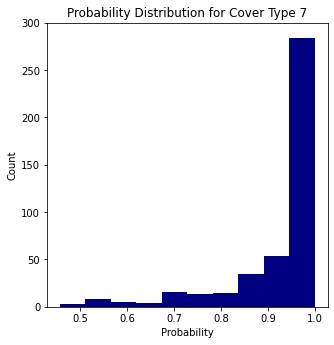

In [23]:
# histograms of probability estimates generated for each label
c_label = [1, 2, 3, 4, 5, 6, 7]
palette = ['purple', 'orange', 'gold', 'pink', 'forestgreen', 'lightblue', 'navy']
dflist = [df_1, df_2, df_3, df_4, df_5, df_6, df_7]
plt.figure(figsize = [18, 9])

for c in c_label:
    plt.figure(figsize = [18, 9])
    plt.subplot(2, 4, c)
    plt.hist(dflist[c-1][1], color = palette[c-1])
    plt.title(f'Probability Distribution for Cover Type {c_label[c-1]}')
    plt.ylabel('Count')
    plt.ylim(0, 300)
    plt.xlabel('Probability')
plt.tight_layout()
plt.show()

From these visualizations, we can see that our model is most confident about Cover Types 7, 4, and 5. This corresponds with the classification report data explored earlier. 